# Projet ML Souleymane Mbaye

In [17]:
import sys
sys.path.append('./')
from src import Loss,Modules
import matplotlib.pyplot as plt
%matplotlib inline  


%load_ext autoreload
%autoreload 2

## 1. Test du Module Linear avec MSELoss sur la classification de chiffres 1 vs 2

In [63]:
import numpy as np
import pickle as pkl

data = pkl.load(open('data/usps.pkl', 'rb'))
X = np.array(data['X_train'], dtype=float) # conversion de type pour une meilleure compatibilité
Y = np.array(data['Y_train'], dtype=float)

where = np.where((Y>0) & (Y<=2))[0]
X12 = X[where]
Y12 = Y[where]
Y12[Y12==1] = 0
Y12[Y12==2] = 1

In [64]:
X_test = np.array(data['X_test'], dtype=float)
Y_test = np.array(data['Y_test'], dtype=float)

where = np.where((Y_test>0) & (Y_test<=2))[0]
X12_test = X_test[where]
Y12_test = Y_test[where]

Y12_test[Y12_test==1] = 0
Y12_test[Y12_test==2] = 1

In [65]:
print(f"Taille de la base: {len(Y)+len(Y_test)}\nShape: {X.shape}")

Taille de la base: 9298
Shape: (6229, 256)


In [214]:
model_lin_1 = Modules.Linear(256,16)
model_tanh = Modules.TanH()
model_lin_2 = Modules.Linear(16,1)
model_sig = Modules.Sigmoid()
loss_fn = Loss.MSELoss()

In [10]:
def creer_batches(X,Y,batch_size=5):
  num_samples = len(Y) # nombre total d'échantillons dans Xtrain
  num_batches = num_samples // batch_size # nombre de batches
  indices = np.arange(num_samples)
  np.random.shuffle(indices) # mélanger les indices

  batches = []

  for i in range(num_batches):
    batch_indices = indices[i * batch_size:(i + 1) * batch_size]
    X_batch = X[batch_indices]
    Y_batch = Y[batch_indices]
    batches.append((X_batch,Y_batch))
  
  # dernier batch qui n'est pas plein
  # if num_samples % batch_size != 0:
  #   X_batch = X[num_batches*batch_size:]
  #   Y_batch = Y[num_batches*batch_size:]
  #   batches.append((X_batch,Y_batch))
  
  return batches

In [11]:
def train(batches,lr=1e-3,v=False):
  l_loss = []
  size = len(batches) * len(batches[0][1])
  
  for batch,(X,y) in enumerate(batches):
    # prediction
    yhat = model_lin_1.forward(X)
    yhat = model_tanh.forward(yhat)
    yhat = model_lin_2.forward(yhat)
    yhat = model_sig.forward(yhat)
    loss_hat = loss_fn.forward(y,yhat).sum()


    # backpropagation
    delta = loss_fn.backward(y,yhat)
    delta = model_sig.backward_delta(delta)

    model_lin_2.zero_grad()
    model_lin_2.backward_update_gradient(delta)
    model_lin_2.update_parameters(lr)
    delta = model_lin_2.backward_delta(delta)

    delta = model_tanh.backward_delta(delta)
    model_lin_1.zero_grad()
    model_lin_1.backward_update_gradient(delta)
    model_lin_1.update_parameters(lr)

    l_loss.append(loss_hat)
    if v and batch % 100 == 0:
      courant = batch * len(X)
      print(f"loss: {loss_hat:>7f} [{courant:>5d}/{size:>5d}]")
  
  return np.mean(l_loss)

def test(batches,v=False):
  num_batches = len(batches)  
  size = num_batches * len(batches[0][1])
  test_loss, correct = 0,0
  
  for X,y in batches:
    yhat = model_lin_1.forward(X)
    yhat = model_tanh.forward(yhat)
    yhat = model_lin_2.forward(yhat)
    yhat = model_sig.forward(yhat)
    test_loss += loss_fn.forward(y,yhat).sum()
    correct += (np.where(yhat.reshape(-1) > 0.5, 1, 0) == y).sum()
  
  test_loss /= num_batches
  correct /= size
  if v:
    print(f"Erreur en test: \n Accuracy: {(100*correct):>0.1f}%, Moy loss: {test_loss:>8f} \n")
  
  return correct,test_loss

In [217]:
train_batches = creer_batches(X12,Y12)
test_batches = creer_batches(X12_test,Y12_test)
learning_rate = 1e-3
l_train_loss = []
l_test_loss = []
l_correct = []
l_correct_train = []
v = False

epochs = 50
for t in range(epochs):
    if v:
        print(f"Epoch {t+1}\n-------------------------------")
    
    train_loss = train(train_batches)
    correct,test_loss = test(test_batches)
    correct_train,test_loss_train = test(train_batches)

    l_train_loss.append(train_loss)
    l_test_loss.append(test_loss)
    l_correct.append(correct)
    l_correct_train.append(correct_train)

print(f"Accuracy train à la fin: \n {(100*l_correct_train[-1]):>0.1f}")
print(f"Accuracy test à la fin: \n {(100*l_correct[-1]):>0.1f}")

Accuracy train à la fin: 
 99.6
Accuracy test à la fin: 
 99.7


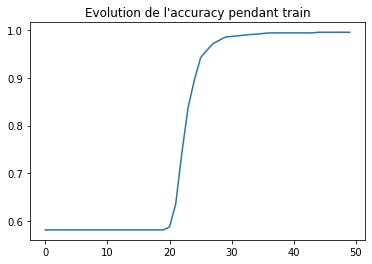

In [218]:
plt.figure()
plt.plot(np.arange(len(l_correct_train)),l_correct_train)
plt.title("Evolution de l'accuracy pendant train")
plt.show()

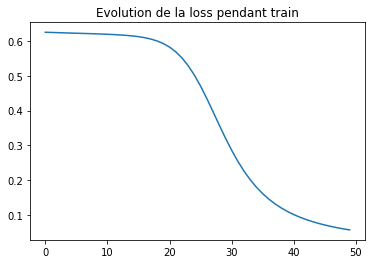

In [219]:
plt.figure()
plt.plot(np.arange(len(l_train_loss)),l_train_loss)
plt.title("Evolution de la loss pendant train")
plt.show()

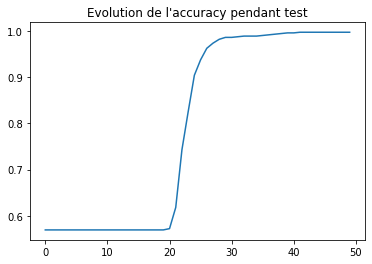

In [220]:
plt.figure()
plt.plot(np.arange(len(l_correct)),l_correct)
plt.title("Evolution de l'accuracy pendant test")
plt.show()

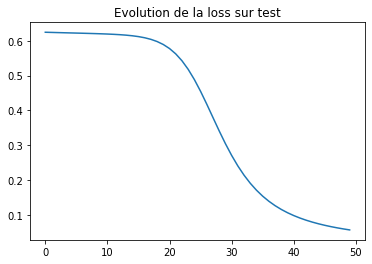

In [221]:
plt.figure()
plt.plot(np.arange(len(l_test_loss)),l_test_loss)
plt.title("Evolution de la loss sur test")
plt.show()

## 2. Test du Module Linear avec la base MNIST

In [98]:
# from sklearn.datasets import fetch_openml

# # Charger la base de données MNIST
# mnist = fetch_openml(name='mnist_784')

# print("Nombre d'observations :", mnist.data.shape)

# X = mnist.data.values
# y = np.array(mnist.target.values, dtype=int)

# with open('data/mnist_data.pkl', 'wb') as f:
#   pkl.dump((X, y), f)

# pour les recharger
# Charger les données à partir du fichier
# with open('data/mnist_data.pkl', 'rb') as f:
#   X, y = pickle.load(f)

In [97]:
X.shape

(70000, 784)

In [86]:


# Charger les données à partir du fichier
with open('data/mnist_data.pkl', 'rb') as f:
  X, y = pkl.load(f)

print(f"Shape: {X.shape}")

where = np.where((y == 0) | (y == 1))[0]
print("y:",y[:5])
X01 = X[where]
y01 = y[where]
print(f"\ntaille de la base totale: {len(y)}\ntaille de la base 0 et 1: {len(y01)}")

L = [i for i in range(len(y01))]
np.random.shuffle(L)

n_80 = int(0.8 * len(y01))

X01_train,y01_train = X01[L[:n_80]],y01[L[:n_80]]
X01_test,y01_test = X01[L[n_80:]],y01[L[n_80:]]

print(f"\nTaille de la base train: {len(y01_train)}\nTaille de la base test: {len(y01_test)}")


Shape: (70000, 784)
y: [5. 0. 4. 1. 9.]

taille de la base totale: 70000
taille de la base 0 et 1: 14780

Taille de la base train: 11824
Taille de la base test: 2956


In [76]:
model_lin_1 = Modules.Linear(784,200)
model_tanh = Modules.TanH()
model_lin_2 = Modules.Linear(200,1)
model_sig = Modules.Sigmoid()
loss_fn = Loss.MSELoss()

In [77]:
train_batches = creer_batches(X01_train,y01_train)
test_batches = creer_batches(X01_test,y01_test)
learning_rate = 1e-3
l_train_loss = []
l_test_loss = []
l_correct = []
l_correct_train = []
v = False

epochs = 50
for t in range(epochs):
    if v:
        print(f"Epoch {t+1}\n-------------------------------")
    
    train_loss = train(train_batches)
    correct,test_loss = test(test_batches)
    correct_train,test_loss_train = test(train_batches)

    l_train_loss.append(train_loss)
    l_test_loss.append(test_loss)
    l_correct.append(correct)
    l_correct_train.append(correct_train)

print(f"Accuracy train à la fin: \n {(100*l_correct_train[-1]):>0.1f}")
print(f"Accuracy test à la fin: \n {(100*l_correct[-1]):>0.1f}")

Accuracy train à la fin: 
 100.0
Accuracy test à la fin: 
 99.9


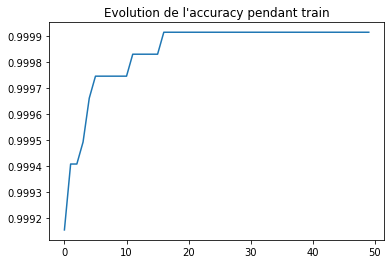

In [79]:
plt.figure()
plt.plot(np.arange(len(l_correct_train)),l_correct_train)
plt.title("Evolution de l'accuracy pendant train")
plt.show()

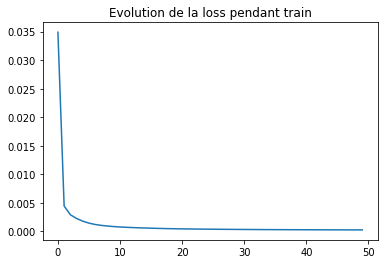

In [80]:
plt.figure()
plt.plot(np.arange(len(l_train_loss)),l_train_loss)
plt.title("Evolution de la loss pendant train")
plt.show()

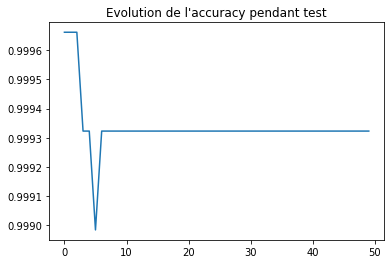

In [81]:
plt.figure()
plt.plot(np.arange(len(l_correct)),l_correct)
plt.title("Evolution de l'accuracy pendant test")
plt.show()

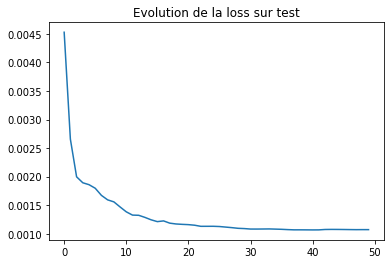

In [82]:
plt.figure()
plt.plot(np.arange(len(l_test_loss)),l_test_loss)
plt.title("Evolution de la loss sur test")
plt.show()

## Les 4 vs les 9

In [90]:
where = np.where((y == 4) | (y == 9))[0]

X49 = X[where]
y49 = y[where]

y49[y49==4] = 0
y49[y49==9] = 1

print(f"\ntaille de la base totale: {len(y)}\ntaille de la base 4 et 9: {len(y49)}")

L = [i for i in range(len(y49))]
np.random.shuffle(L)

n_80 = int(0.8 * len(y49))

X49_train,y49_train = X49[L[:n_80]],y49[L[:n_80]]
X49_test,y49_test = X49[L[n_80:]],y49[L[n_80:]]

print(f"\nTaille de la base train: {len(y49_train)}\nTaille de la base test: {len(y49_test)}")



taille de la base totale: 70000
taille de la base 4 et 9: 13782

Taille de la base train: 11025
Taille de la base test: 2757


In [91]:
model_lin_1 = Modules.Linear(784,200)
model_tanh = Modules.TanH()
model_lin_2 = Modules.Linear(200,1)
model_sig = Modules.Sigmoid()
loss_fn = Loss.MSELoss()

In [92]:
train_batches = creer_batches(X01_train,y01_train)
test_batches = creer_batches(X01_test,y01_test)
learning_rate = 1e-3
l_train_loss = []
l_test_loss = []
l_correct = []
l_correct_train = []
v = False

epochs = 50
for t in range(epochs):
    if v:
        print(f"Epoch {t+1}\n-------------------------------")
    
    train_loss = train(train_batches)
    correct,test_loss = test(test_batches)
    correct_train,test_loss_train = test(train_batches)

    l_train_loss.append(train_loss)
    l_test_loss.append(test_loss)
    l_correct.append(correct)
    l_correct_train.append(correct_train)

print(f"Accuracy train à la fin: \n {(100*l_correct_train[-1]):>0.1f}")
print(f"Accuracy test à la fin: \n {(100*l_correct[-1]):>0.1f}")

Accuracy train à la fin: 
 100.0
Accuracy test à la fin: 
 99.9


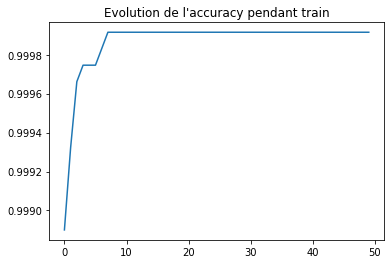

In [93]:
plt.figure()
plt.plot(np.arange(len(l_correct_train)),l_correct_train)
plt.title("Evolution de l'accuracy pendant train")
plt.show()

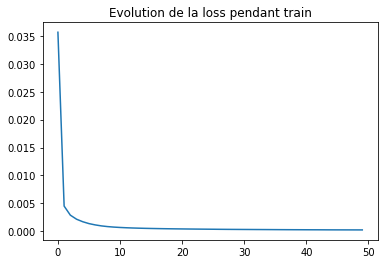

In [94]:
plt.figure()
plt.plot(np.arange(len(l_train_loss)),l_train_loss)
plt.title("Evolution de la loss pendant train")
plt.show()

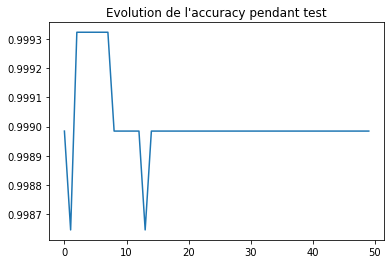

In [95]:
plt.figure()
plt.plot(np.arange(len(l_correct)),l_correct)
plt.title("Evolution de l'accuracy pendant test")
plt.show()

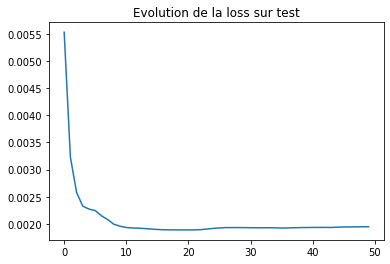

In [96]:
plt.figure()
plt.plot(np.arange(len(l_test_loss)),l_test_loss)
plt.title("Evolution de la loss sur test")
plt.show()

## 3. Test du Module Linear avec la base Fashion-MNIST

In [109]:
# # ! pip install tensorflow
# import tensorflow as tf

# # Télécharger la base de données Fashion-MNIST
# fashion_mnist = tf.keras.datasets.fashion_mnist
# (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [110]:
# with open('data/fashion_mnist_data.pkl', 'wb') as f:
#   pkl.dump(((X_train, y_train), (X_test, y_test)), f)

In [117]:
# Charger les données à partir du fichier
with open('data/fashion_mnist_data.pkl', 'rb') as f:
  (X_train, y_train), (X_test, y_test) = pkl.load(f)

X_train = X_train.reshape((len(X_train),-1))
X_test = X_test.reshape((len(X_test),-1))
print(f"Taille train: {X_train.shape}\nTaille test: {X_test.shape}")

where = np.where((y_train == 0) | (y_train == 1))[0]
X01_train = X_train[where]
y01_train = y_train[where]

where = np.where((y_test == 0) | (y_test == 1))[0]
X01_test = X_test[where]
y01_test = y_test[where]
print(f"\nTaille de la base train: {len(y01_train)}\nTaille de la base test: {len(y01_test)}")

Taille train: (60000, 784)
Taille test: (10000, 784)

Taille de la base train: 12000
Taille de la base test: 2000


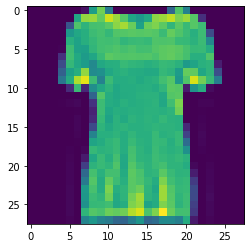

In [125]:
plt.imshow(X_train[10].reshape((28,28)))

In [118]:
model_lin_1 = Modules.Linear(784,200)
model_tanh = Modules.TanH()
model_lin_2 = Modules.Linear(200,1)
model_sig = Modules.Sigmoid()
loss_fn = Loss.MSELoss()

In [119]:
train_batches = creer_batches(X01_train,y01_train)
test_batches = creer_batches(X01_test,y01_test)
learning_rate = 1e-3
l_train_loss = []
l_test_loss = []
l_correct = []
l_correct_train = []
v = False

epochs = 50
for t in range(epochs):
    if v:
        print(f"Epoch {t+1}\n-------------------------------")
    
    train_loss = train(train_batches)
    correct,test_loss = test(test_batches)
    correct_train,test_loss_train = test(train_batches)

    l_train_loss.append(train_loss)
    l_test_loss.append(test_loss)
    l_correct.append(correct)
    l_correct_train.append(correct_train)

print(f"Accuracy train à la fin: \n {(100*l_correct_train[-1]):>0.1f}")
print(f"Accuracy test à la fin: \n {(100*l_correct[-1]):>0.1f}")

Accuracy train à la fin: 
 99.8
Accuracy test à la fin: 
 99.2


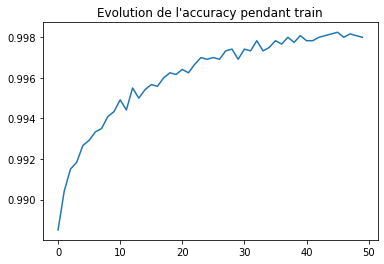

In [120]:
plt.figure()
plt.plot(np.arange(len(l_correct_train)),l_correct_train)
plt.title("Evolution de l'accuracy pendant train")
plt.show()

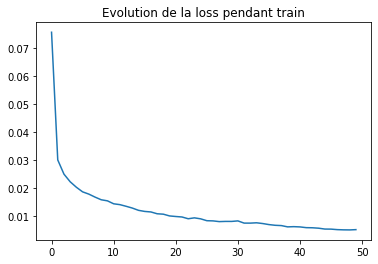

In [121]:
plt.figure()
plt.plot(np.arange(len(l_train_loss)),l_train_loss)
plt.title("Evolution de la loss pendant train")
plt.show()

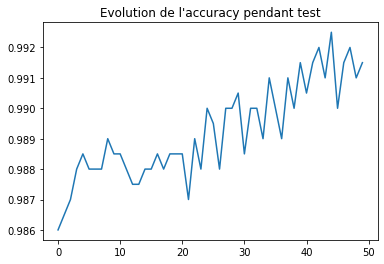

In [122]:
plt.figure()
plt.plot(np.arange(len(l_correct)),l_correct)
plt.title("Evolution de l'accuracy pendant test")
plt.show()

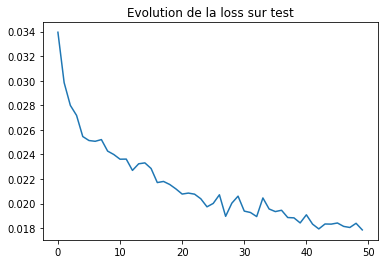

In [123]:
plt.figure()
plt.plot(np.arange(len(l_test_loss)),l_test_loss)
plt.title("Evolution de la loss sur test")
plt.show()